# Real data asymmetry

We calculate different asymmetry values for the HST, HSC, and SDSS data (and later, UNIONS) using our 4 different methods. The idea is that each galaxy should have the same asymmetry in different imaging, regardless of the instrument Fingers crossed...

Try two approaches:

1. Use a detection map based on HSC to mask other sources. Use the same segmap in all three cases.
2. Create a different detection map for each image

**For deconvolution, convert all images to 0.1 arcsec/px**

#### Imports

In [2]:
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import petrofit as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from astropy.io import fits
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog
from photutils.profiles import CurveOfGrowth, RadialProfile
from astropy.convolution import Gaussian2DKernel, convolve, Tophat2DKernel, Box2DKernel
from astropy.stats import sigma_clipped_stats, sigma_clip
from reproject import reproject_interp, reproject_adaptive, reproject_exact
from astropy.visualization import AsymmetricPercentileInterval, AsinhStretch
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.wcs import WCS
from photutils.centroids import centroid_com
from scipy import optimize as opt
import photutils as phot
from skimage import measure
from asymmetry import get_asymmetry, fourier_deconvolve, _asymmetry_func, _sky_properties
from skimage import transform as T
from astropy.convolution import interpolate_replace_nans
from scipy import fft
from matplotlib import patches, colors
from scipy.signal import savgol_filter

norm = AsymmetricPercentileInterval(10, 99.6)
stretch = AsinhStretch(0.6)

example = True
# exname = 'J234116+000021'
exname = 'J000318+004844'
desired_pxscale = 0.15

In [3]:
plt.rcParams['image.interpolation'] = 'None'

Load in the data frame:

In [4]:
df = pd.read_csv('data/catalogs/data.csv')
df = df[df.hsc]
df.head(3)

name        ra       dec    lmass50         z      dataset  \
0  J000318+004844  0.825888  0.812301  10.820000  0.138889         spog   
1  J001145-005431  2.938389 -0.908503  10.221996  0.047883         spog   
2  J002232+002127  5.632805  0.357513  10.150000  0.047105  control_sfg   

    cfis   hsc  
0  False  True  
1  False  True  
2  False  True

Load in an example galaxy:

In [5]:
if example:
    ex_sdss_f = fits.open(f'data/sdss/i/{exname}.fits')
    ex_hst_f = fits.open(f'data/hst/F814W/{exname}.fits')
    ex_hsc_f = fits.open(f'data/hsc/{exname}.fits')
    ex_inf = df[df['name'] == exname].iloc[0]
    ex_files = [ex_sdss_f, ex_hst_f, ex_hsc_f]

Populate the pxscale and zp fields in the fits files if missing

In [6]:
def get_pxscale_zp(f, instrument):
    
    if instrument == 'SDSS':
        pxscale = 0.396
        zp = 22.5
    elif instrument == 'HSC':
        pxscale = 0.169
        zp = 2.5*np.log10(f[0].header['FLUXMAG0'])
    elif instrument == 'HST':
        pxscale = f[0].header['pxscale']
        zp = f[0].header['zp']
    return pxscale, zp
    
if example:
    order = ['SDSS', 'HST', 'HSC']
    for name, f in zip(order, ex_files):
        pxscale, zp = get_pxscale_zp(f, name)
        f[0].header['pxscale'] = pxscale
        f[0].header['zp'] = zp

        # Rotate the SDSS images
        if name == 'SDSS':
            extnames = ['IMAGE','ERR','MASK']
            for ext in extnames:
                f[ext].data = f[ext].data[::-1].T

Pad the PSF to match image size:

In [7]:
if example:
    for f in ex_files:
        img = f['IMAGE'].data
        psf = f['PSF'].data
        shape = img.shape
        padsize = (shape[0] - psf.shape[0], shape[1] - psf.shape[1])  # total amount of padding
        psf = np.pad(psf, (((padsize[0]+1)//2, padsize[0]//2), ((padsize[1]+1)//2, padsize[1]//2)), mode='constant')
        f['PSF'].data = psf / np.sum(psf)

## Functions

We need to do these three steps:

1. Detect and mask extraneous sources using `detect_sources`
2. Calculate the Petrosian radius
3. Calculate asymmetry four ways
    1. CAS asymmetry as defined by statmorph
    2. Corrected CAS asymmetry (normalized by $F$ not $|F|$)
    3. Squared asymmetry
    4. Fourier squared asymmetry
    

### Utility plot

Given SDSS, HST, and HSC files, make a 3-subplot figure in the SDSS projection

In [8]:
def make_cutout(files):
    
    # Make axes
    fig = plt.figure(figsize=(13,4))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    
    # Plot the three subplots
    labels = ['SDSS', 'HST', 'HSC']
    axs = []
    for i, (f, label) in enumerate(zip(files, labels)):
        # Plot the galaxy
        ax = fig.add_subplot(1,3,i+1)#
        axs.append(ax)
        img = -2.5*np.log10(np.abs(f[0].data)/f[0].header['pxscale']**2) + f[0].header['zp']
        im = ax.imshow(img, cmap='gray_r', vmin=20, vmax=28)
        size = 40/f[0].header['pxscale']
        cent = 40/f[0].header['pxscale']
        ax.set_xlim(cent-size, cent+size)
        ax.set_ylim(cent-size, cent+size)
        ax.axis('off')
        
        # Add a label
        color = 'w' if np.sum(img[:10,:10]) > 1000 else 'k'
        ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color=color, size=16, va='top')
    
    # Add a colorbar
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
    cax = fig.add_axes([0.955, 0, 0.015, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    
    return fig, axs

/tmp/ipykernel_25103/2212916305.py:14: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f[0].data)/f[0].header['pxscale']**2) + f[0].header['zp']


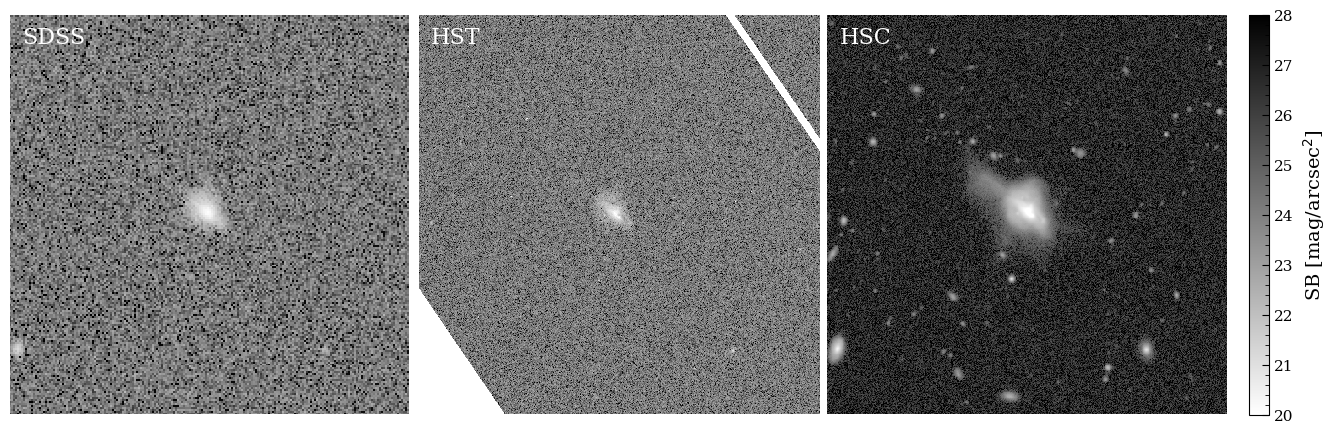

In [9]:
if example:
    make_cutout(ex_files)

### Detect sources

#### Make segmap

* Convolve the data with a small Gaussian kernel to smooth the noise a bit
* Detect all sources in the image using a $5\sigma$ threshold to detect only bright objects
* Mask sources that are not the main object

**Create independent segmentation maps (more realistic)**

**Following the method from the 2021 paper**

In [10]:
def make_segmap(file, center_arcsec=15):
    
    # Get the image and the mask
    img = file['IMAGE'].data
    mask = file['MASK'].data
    pxscale = file['IMAGE'].header['pxscale']
    
    # Convolve the image
    img_conv = convolve(img, Tophat2DKernel(5))
    
    # Find the background level
    bgmean, bgmed, bgsd = sigma_clipped_stats(img, sigma=3, mask=mask)

    # Hot mode: all small bright objects
    hot_thresh = np.quantile(img_conv, 0.98)
    segmap_hot = detect_sources(img_conv, threshold=hot_thresh, npixels=1, mask=mask)
    
    # Cool mode: extended faint sources
    cool_thresh = 1
    cool_size = int((1 / pxscale)**2 + 0.5) # 1 arcsec2
    segmap_cool = detect_sources(img_conv, threshold=cool_thresh*bgsd, npixels=cool_size, mask=mask)
    segmap_cool = deblend_sources(img_conv, segmap_cool, npixels=cool_size, contrast=1e-6, nlevels=32, progress_bar=False)
    
    ##### Mask contaminants
    # Mask all cool segments more than 15" away and all cool segments within 2Rp that have a hot segment (excluding center)

    # For masking purposes, get rid of the galaxy label from the segmaps
    xc = int(img.shape[0]/2 + 0.5)
    gal_label_cool = segmap_cool.data[xc, xc]
    gal_label_hot = segmap_hot.data[xc, xc]
    mask_cool = segmap_cool.copy()
    mask_hot = segmap_hot.copy()
    mask_cool.remove_label(gal_label_cool)
    mask_hot.remove_label(gal_label_hot)
    
    # For each cool segment, mask if it's 1) outside the center or 2) overlaps with a hot segment
    for seg in mask_cool.segments:
        keep_masked = False
        # Check if outside 15 arcsec
        dist = np.sum((np.array(seg.bbox.center)-xc)**2)
        
        if dist < center_arcsec/pxscale:
            # If yes, check if overlaps with a hot segment
            for hotseg in mask_hot.segments:
                
                if np.sum((np.array(seg.bbox.center)-xc)**2) > center_arcsec/pxscale: continue
                arr_cool = mask_cool.data
                arr_hot = mask_hot.data
                overlap_area = (arr_cool == seg) & (arr_hot == hotseg)
                overlap_fraction = overlap_area / hotseg.area
                if overlap_fraction >= 0.8:  
                    keep_masked = True
                    break                
        else:
            keep_masked = True
                
        if not keep_masked:
            mask_cool.remove_label(seg)
            
        
    ##### Cold mode
    mask_segmap = mask | (mask_cool.data > 0)
    segmap_cool = detect_sources(img_conv, threshold=cool_thresh*bgsd, npixels=1, mask=mask_segmap)
    gal_label = segmap_cool.data[xc,xc]
    
    # Save the galaxy only segmap
    segmap_final = segmap_cool.copy()
    segmap_final.keep_label(gal_label)
    
    # Finally mask all remaining small things
    segmap_cool.remove_label(gal_label)
    mask_segmap = mask_segmap | (segmap_cool.data > 0)
    
    # Grow the mask by 10% of the image size
    size = int(0.05*img.shape[0])
    mask_segmap = convolve(mask_segmap, Box2DKernel(size))
    mask_segmap = mask_segmap > 0.1
    
    return mask_segmap, segmap_final

#### Project an HSC segmap onto another WCS

Adapt the HSC-based segmap to the HST/SDSS orientation, pixel scale etc using `reproject`.

In [11]:
# def convert_segmap(mask, hsc_f, file):
#     mask_proj, area = reproject_interp((mask, hsc_f[0].header), file[0].header, order=0)
#     mask_proj = (mask_proj.astype(bool) | ~area.astype(bool)).astype(int)
#     return mask_proj


Show an example:

/tmp/ipykernel_25103/2212916305.py:14: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f[0].data)/f[0].header['pxscale']**2) + f[0].header['zp']


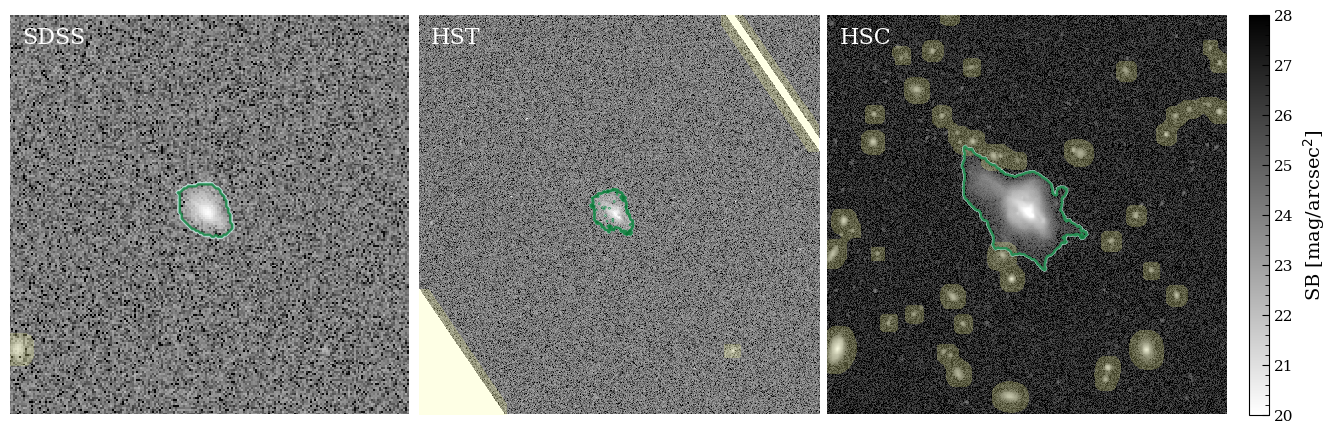

In [12]:
if example:
    segmasks, segmaps = [], []
    fig, axs = make_cutout(ex_files)
    
    for ax, f in zip(axs, ex_files):
        segmask, segmap = make_segmap(f)
        segmasks.append(segmask)
        segmaps.append(segmap)
        ax.contourf(segmask, cmap='terrain', levels=[0.9, 1.1], alpha=0.25)
        ax.contour(segmap.data, cmap='BuGn', alpha=0.5)

### Petrosian radius

Use `petrofit` to calculate Petrosian radius

In [13]:
def get_petrosian(file, segmap, mask):

    img = file['IMAGE'].data
    err = file['ERR'].data
    pxscale = file['IMAGE'].header['pxscale']

    # List of radii going down to 15 arcsec
    radii = np.arange(1, 15/pxscale, 1)

    # Source properties including centroid
    source = SourceCatalog(img, segmap, mask=mask)[0]

    # Curve of growth
    rp = RadialProfile(img, source.centroid, radii,  error=err, mask=mask)
    cog = CurveOfGrowth(img, source.centroid, radii, error=err, mask=mask)

    # Petrosian radius
    fluxes, areas, errs = cog.profile, cog.area, cog.profile_error
    p = pf.Petrosian(radii, areas, fluxes, errs)

    # Return petrosian radius in arcsec and centroid
    return p.r_petrosian*pxscale, source.centroid

Example:

/tmp/ipykernel_25103/2212916305.py:14: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f[0].data)/f[0].header['pxscale']**2) + f[0].header['zp']


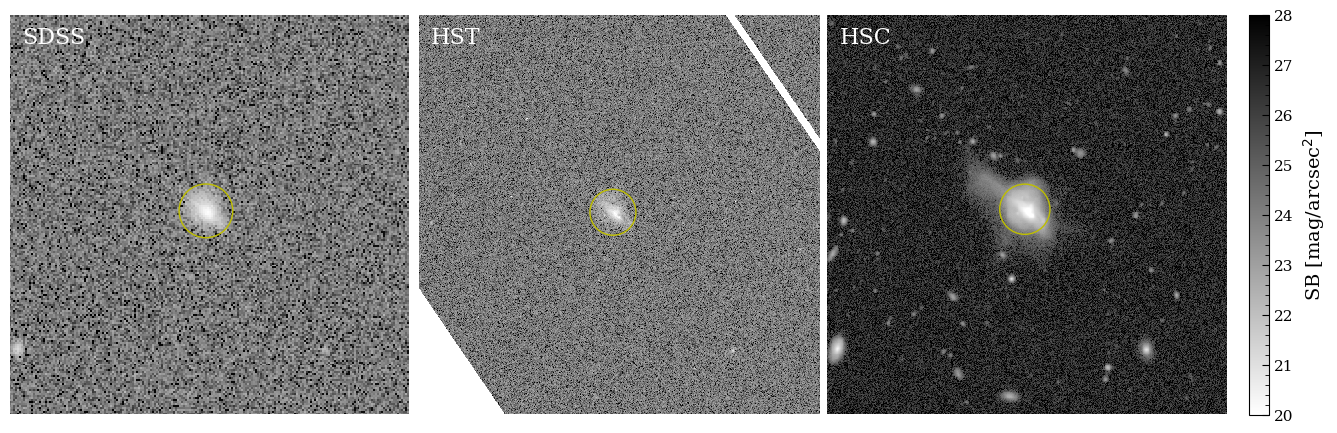

In [14]:
if example:
    
    rpets = []
    cents = []
    
    fig, axs = make_cutout(ex_files)
    for ax, segmask, segmap, f in zip(axs, segmasks, segmaps, ex_files):
        
        # Calculate rpet
        rpet, cent = get_petrosian(f, segmap, segmask)
        rpets.append(rpet)
        cents.append(cent)
        
        # ax.contourf(segmask, cmap='Spectral', levels=[0.9, 1.1], alpha=0.5)
        ap = phot.aperture.CircularAperture(cent, rpet/f[0].header['pxscale'])
        ap.plot(ax=ax, color='y', lw=1)

## Asymmetry functions

For the "corrected" asymmetry, we need to match spatial resolution. 
* If the image is too high-res, convolve with a nyquist PSF & downscale the image
* If the image is low res, upscale it & deconvolve down to nyquist sampling


In [15]:
def get_a_values(img, rpet, mask, psf, err, instrument, pxscale, ap_factor=1.5):
    """Calculate CAS and RMS asymmetries, including the corrected versions. For RMS asymmetry, deconvolve for correction.
    
    Args:
        img: np.array
        rpet: Petrosian radius in arcsec
        mask: mask with any artifacts and contaminant sources
        err: standard deviation uncertainty
        pxscale: pixel scale of the image
        ap_factor: out to how many Petrosian radii are included in asymmetry calculation
    Returns:
        dict with four asymmetries and their centroids
    """
    
    ap_size = ap_factor*rpet/pxscale
    
    # Non-fourier asymmetries
    a_sq = get_asymmetry(img, ap_size, mask, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[2, 3])
    a_cas = get_asymmetry(img, ap_size, mask, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[2, 3])
    a_cas_corr = get_asymmetry(img, ap_size, mask, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[2,3])

    ##### Corrected RMS A
    # First, decide if we need to scale up or down
    factor = desired_pxscale / pxscale
    
    # Ok we have three cases
    # 1) Pixel scale is far larger than real image - no need to deconvolve, just need to convolve with Nyquist PSF
    # 2) Pixel scale is similar: real PSF larger > need to deconvolve, real PSF smaller > no need
    # 3) Large pixel scale: need to deconvolve & convolve with Nyquist
    # HSC seeing is about 0.6" so if rescaling to 0.15" we need to deconvolve
    
    # Mask the contaminants as they can mess up deconvolution
    _, _, bgsd = sigma_clipped_stats(img, mask=mask)
    img_masked = img.copy()
    noise = np.random.normal(loc=0, scale=bgsd, size=img.shape)
    img_masked[mask] = noise[mask]
    err[mask | np.isnan(err)] = bgsd
        
    # Downscaling: convolve the original image with a nyquist PSF, rescale, then simply calculate RMS A
    if (instrument == 'HST'):       
        
        # Convolve to Nyquist
        nyquist_size = 3*gaussian_fwhm_to_sigma*factor
        psf_nyq = Gaussian2DKernel(nyquist_size)
        img_deconv = convolve(img, psf_nyq)
        
        
        # Rescale
        img_deconv = T.rescale(img_deconv, 1/factor) * factor**2
        mask = T.rescale(mask, 1/factor, order=0)

        # Convolve down to Nyquist
        # nyquist_size = 3*gaussian_fwhm_to_sigma
        # psf_nyq = Gaussian2DKernel(nyquist_size)
        # img_deconv = convolve(img_deconv, psf_nyq)
        
        # Calculate squared asymmetry
        a_fourier = get_asymmetry(
            img_deconv, ap_size/factor, mask, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[2, 3]
        )
        
    # Upscaling: mask foregrounds, upscale, then deconvolve, then calculate RMS A
    else:
        
        # Upscale the image
        img_rescaled = T.rescale(img_masked, 1/factor) * factor**2
        err_rescaled = T.rescale(err, 1/factor) * factor**2 
        psf_rescaled = T.rescale(psf, 1/factor, order=5) * factor**2
        psf_rescaled /= np.sum(psf_rescaled)
        mask_rescaled = T.rescale(mask, 1/factor, order=0) > 0.1
        
        # Deconvolve
        img_deconv = np.nan * np.ones_like(img_rescaled)
        count = 0
        while np.all(np.isnan(img_deconv)) and count<10:
            img_deconv = fourier_deconvolve(img_rescaled, psf_rescaled, err_rescaled, convolve_nyquist=True)
            count += 1
    
        # Fourier asymmetry, if deconvolution failed return nan
        if np.all(np.isnan(img_deconv)):
            a_fourier = [np.nan, [0,0]]
        else:
            a_fourier = get_asymmetry(
                img_deconv, ap_size/factor, mask_rescaled, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[2, 3]
            )

    # Return all measurements
    res = { 'a_cas' : a_cas[0], 'a_cas_corr' : a_cas_corr[0], 'a_sq' : np.sqrt(a_sq[0]), 'a_fourier' : np.sqrt(a_fourier[0]),
          'cent_cas' : a_cas[1], 'cent_cas_corr' : a_cas_corr[1], 'cent_sq' : a_sq[1], 'cent_fourier' : a_fourier[1]}
    return res, img_deconv

In [16]:
# from asymmetry import _fit_snr
# from scipy.ndimage import uniform_filter

# i = 0

# img = ex_files[i][0].data
# err = ex_files[i]['ERR'].data
# mask = segmasks[i]
# psf = ex_files[i]['PSF'].data
# pxscale = ex_files[i][0].header['pxscale']
# zp = ex_files[i][0].header['zp']

# factor = desired_pxscale/pxscale

# img_rescaled = T.rescale(img, 1/factor) * factor**2
# err_rescaled = T.rescale(err, 1/factor) * factor**2 
# psf_rescaled = T.rescale(psf, 1/factor, order=5) * factor**2
# psf_rescaled /= np.sum(psf_rescaled)
# mask_rescaled = T.rescale(mask, 1/factor, order=0) > 0.1
# noise = np.random.normal(loc=0, scale=np.abs(err_rescaled), size=img_rescaled.shape)

# noise_fft = np.abs(fft.fft2(noise, norm='ortho'))
# # # Smooth the noise map
# filtsize = max([3,int(noise_fft.shape[0]*0.1)])
# # noise_fft = savgol_filter(noise_fft, axis=0, window_length=filtsize, polyorder=2)
# # noise_fft = savgol_filter(noise_fft, axis=1, window_length=filtsize, polyorder=2)
# noise_fft = uniform_filter(noise_fft, filtsize)


# img_fft = fft.fft2(img_rescaled, norm='ortho')
# # noise_fft = fft.fft2(noise, norm='ortho')
# psf_fft = fft.fft2(fft.ifftshift(psf_rescaled), norm='backward')

# snr_simple = np.abs(img_fft) / np.abs(noise_fft)
# snr = _fit_snr(img_fft, noise_fft, psf_fft)

# nyquist_size = 3*gaussian_fwhm_to_sigma # FWHM = 3 x pxscale, sigma ~ 0.4 x FWHM
# nyquist_psf = Gaussian2DKernel(nyquist_size, x_size=img_rescaled.shape[1], y_size=img_rescaled.shape[0])
# nyquist_fft = fft.fft2(fft.ifftshift(nyquist_psf), norm='backward')
# H = (nyquist_fft + 1/snr) / (psf_fft + 1/snr)

# img_corr = img_fft * H
# img_deconv = fft.ifft2(img_corr, norm='ortho')

# img_deconv = fourier_deconvolve(img_rescaled, psf_rescaled, err_rescaled, convolve_nyquist=True)

In [ ]:
if example:
    res_arr = []
    fourier_imgs = []
    
    for ax, f, rpet, mask, instrument in zip(axs, ex_files, rpets, segmasks, order):
        res, img_fourier = get_a_values(
            f['IMAGE'].data.astype(float), rpet, mask,  
            f['PSF'].data, f['ERR'].data, instrument, f[0].header['pxscale'])
        res_arr.append(res)
        fourier_imgs.append(img_fourier)
        
    res_arr = pd.DataFrame(res_arr)
    
res_arr

In [ ]:
if example:
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    zps = [2.5*9, ex_hst_f[0].header['zp'], 2.5*np.log10(ex_hsc_f[0].header['FLUXMAG0'])]

    for ax, img, zp in zip(axs, fourier_imgs, zps):

        im = -2.5*np.log10(np.abs(img/desired_pxscale**2)) + zp
        ax.imshow(im, vmin=20, vmax=28, cmap='gray_r')
        # ax.contour(ex_mask, alpha=0.5)
        
        ax.axis('off')
    plt.subplots_adjust(wspace=0.01)

## HSC-based segmaps

### Create segmaps

For each galaxy, create a segmap, and plot 

In [ ]:
res_df = []
fourier_images = []

sample = df

for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    
    if row['name'] != exname: continue
    
    # if idx<27: continue
    # if idx < 57: continue
    if idx == 25: continue
    if idx == 26: continue
    if idx == 56: continue
    if idx == 67: continue
    
    # Open files
    sdss_f = fits.open(f'data/sdss/i/{row["name"]}.fits')
    hst_f = fits.open(f'data/hst/F814W/{row["name"]}.fits')
    hsc_f = fits.open(f'data/hsc/{row["name"]}.fits')
    files = [sdss_f, hst_f, hsc_f]
    
    # For SDSS and HSC, populate pxscale and zp values
    sdss_f[0].header['zp'] = 22.5
    sdss_f[0].header['pxscale'] = 0.396
    hsc_f[0].header['pxscale'] = 0.169
    hsc_f[0].header['zp'] = 2.5*np.log10(hsc_f[0].header['FLUXMAG0'])
    
    # Flip the SDSS image
    extnames = ['IMAGE','PSF','ERR']
    for ext in extnames:
        sdss_f[ext].data = sdss_f[ext].data[::-1].T
    
    # Pad the PSFs
    for f in files:
        img = f['IMAGE'].data
        psf = f['PSF'].data
        shape = img.shape
        padsize = (shape[0] - psf.shape[0], shape[1] - psf.shape[1])  # total amount of padding
        psf = np.pad(psf, (((padsize[0]+1)//2, padsize[0]//2), ((padsize[1]+1)//2, padsize[1]//2)), mode='constant')
        f['PSF'].data = psf / np.sum(psf)
        
    
    # Create segmaps and calculate rpet
    masks, segmaps, rpets = [], [], []
    for f in files:
        mask, segmap = make_segmap(f)
        rpet = get_petrosian(f, segmap, mask)[0]
        masks.append(mask)
        segmaps.append(segmap)
        rpets.append(rpet)

    # Calculate asymmetry
    instruments = ['SDSS', 'HST', 'HSC']
    res_arrs = []
    imgs_deconv = []
    for i, (f, mask, rpet, instrument) in enumerate(zip(files, masks, rpets, instruments)):

        res, img_deconv = get_a_values(
            f['IMAGE'].data.astype(float), rpet, mask,  
            f['PSF'].data, f['ERR'].data, instrument, f[0].header['pxscale'])
        
        res['name'] = row['name']
        res['instrument'] = instrument
        res_df.append(res)
        res_arrs.append(res)
        imgs_deconv.append(img_deconv)
    fourier_images.append(imgs_deconv)
        
    ############# Plot ############################
    # Make axes
    fig = plt.figure(figsize=(13,8))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

    # Define image size
    size = 30/desired_pxscale
    cent = 40/desired_pxscale
    
    labels = ['SDSS', 'HST', 'HSC']
    axs = []
    for i, (f, mask, label, img_deconv, res) in enumerate(zip(files, masks, labels, imgs_deconv, res_arrs)):
        
        # Convert to SB units
        img = -2.5*np.log10(np.abs(f['IMAGE'].data) / f[0].header['pxscale']**2) + f[0].header['zp']
        img_deconv = -2.5*np.log10(np.abs(img_deconv) / desired_pxscale**2) + f[0].header['zp']
        
        # Make axes
        ax = fig.add_subplot(2,3,(i+1))
        ax_deconv = fig.add_subplot(2,3,(i+4))
        
        # Plot the images
        im = ax.imshow(img, cmap='gray_r', vmin=20, vmax=28)
        ax_deconv.imshow(img_deconv, cmap='gray_r', vmin=20, vmax=28)
        
        # Overplot the masks
        mask_rescaled = T.rescale(mask, f[0].header['pxscale']/desired_pxscale, order=0)
        ax.contourf(mask, cmap='terrain', levels=[0.9, 1.1], alpha=0.3)
        ax_deconv.contourf(mask_rescaled, cmap='terrain', levels=[0.9, 1.1], alpha=0.3)
        
        # Overplot 1.5xRpet
        ap_rpet = phot.aperture.CircularAperture(res['cent_cas'], 1.5*rpet/f[0].header['pxscale'])
        ap_rpet.plot(ax=ax, color='w', lw=1)
        ap_rpet = phot.aperture.CircularAperture(res['cent_fourier'], 1.5*rpet/desired_pxscale)
        ap_rpet.plot(ax=ax_deconv, color='w', lw=1)
        
        # Overplot the sky annulus
        skyap_rpet = phot.aperture.CircularAnnulus(res['cent_cas'], 2*1.5*rpet/f[0].header['pxscale'], 3.0*1.5*rpet/f[0].header['pxscale'], )
        skyap_rpet.plot(ax=ax, fc='C9', alpha=0.3, fill=True)
        skyap_rpet = phot.aperture.CircularAnnulus(res['cent_fourier'], 2*1.5*rpet/desired_pxscale, 3.0*1.5*rpet/desired_pxscale)
        skyap_rpet.plot(ax=ax_deconv, fc='C9', alpha=0.3, fill=True)
        
        # Add a label for the instrument
        # color = 'w' 
        ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=16, va='top')
        
        # Add labels for asymmetry measurements
        ax.annotate(f'CAS |A|={res["a_cas"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax.annotate(fr'Corrected |A|={res["a_cas_corr"]:0.2f}', xy=(0.97, 0.89), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax.annotate(fr'$A_{{RMS}}$={res["a_sq"]:0.2f}', xy=(0.97, 0.81), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        ax_deconv.annotate(fr'$A_{{RMS, 0.2^{{\prime\prime}}}}={res["a_fourier"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', size=16, va='top', ha='right')
        
        axs.append([ax, ax_deconv])
        
    # Set axis limits
    axs = np.array(axs)
    for ax in axs.flatten():
        ax.axis('off')
        # ax.set_xlim(cent-size, cent+size)
        # ax.set_ylim(cent-size, cent+size)
        
    # Add a colorbar
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
    cax = fig.add_axes([0.955, 0, 0.015, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    
    plt.savefig(f'figures/asym_new_0_15/{row["name"]}.pdf', bbox_inches='tight')
    plt.close(fig)
        
    for f in files:
        f.close()

In [ ]:
res_df = pd.DataFrame(res_df)
res_df

In [ ]:
with open('data/fourier_images_0_15_new.pkl', 'wb') as f:
    pickle.dump(fourier_images, f)
    
with open('data/res_df_0_15_new.pkl', 'wb') as f:
    pickle.dump(res_df, f)

In [58]:
remove = ['J141910+525151','J095902+021127']

res_df_good = res_df
res_df_good = res_df[~res_df.name.isin(remove)]
res_df_good = res_df_good.drop_duplicates(subset=['name','instrument'])

sdss = res_df_good[res_df_good.instrument == 'SDSS']
hsc =  res_df_good[res_df_good.instrument == 'HSC']
hst =  res_df_good[res_df_good.instrument == 'HST']

# exclude

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(8, 5), sharey='row')

dfs1 = [hst, hst, hsc]
dfs2 = [sdss, hsc, sdss]

s = 60
for i in range(3):
    
    # Plot the data points
    axs[0,i].scatter(dfs1[i].a_cas, dfs2[i].a_cas, s=s, color='#FFBA0A')
    axs[0,i].scatter(dfs1[i].a_cas_corr, dfs2[i].a_cas_corr, s=s, color='#319')#'#00A7E1')
    axs[1,i].scatter(dfs1[i].a_sq, dfs2[i].a_sq, s=s, color='#FFBA0A')
    axs[1,i].scatter(dfs1[i].a_fourier, dfs2[i].a_fourier, s=s, color='#319')#'#00A7E1')
    
# Calculate the mean error and deviation
for i in range(3):
    
    a_cas_qs = np.nanquantile(dfs1[i].a_cas.values - dfs2[i].a_cas.values, q=[0.16, 0.5, 0.84])
    a_cas_corr_qs = np.nanquantile(dfs1[i].a_cas_corr.values - dfs2[i].a_cas_corr.values, q=[0.16, 0.5, 0.84])
    a_sq = np.nanquantile(dfs1[i].a_sq.values - dfs2[i].a_sq.values, q=[0.16, 0.5, 0.84])
    a_sq_corr = np.nanquantile(dfs1[i].a_fourier.values - dfs2[i].a_fourier.values, q=[0.16, 0.5, 0.84])
    
    
#     # Plot them
#     axs[0,i].annotate(fr'$\Delta|A|$={a_cas_corr_qs[1]:0.2f}$^{{+{a_cas_corr_qs[2]-a_cas_qs[1]:0.2f} }}_{{-{a_cas_corr_qs[1]-a_cas_qs[0]:0.2f} }}$', 
#                       color='#319', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
    
#     axs[0,i].annotate(fr'$\Delta|A|$={a_cas_qs[1]:0.2f}$^{{+{a_cas_qs[2]-a_cas_qs[1]:0.2f} }}_{{-{a_cas_qs[1]-a_cas_qs[0]:0.2f} }}$', 
#                       color='#EE990A', xy=(0.05, 0.84), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
#     axs[1,i].annotate(fr'$\Delta|A|$={a_sq[1]:0.2f}$^{{+{a_sq[2]-a_sq[1]:0.2f} }}_{{-{a_sq[1]-a_sq[0]:0.2f} }}$', 
#                       color='#319', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
#     axs[1,i].annotate(fr'$\Delta|A|$={a_sq_corr[1]:0.2f}$^{{+{a_sq_corr[2]-a_sq_corr[1]:0.2f} }}_{{-{a_sq_corr[1]-a_sq_corr[0]:0.2f} }}$', 
#                       color='#EE990A', xy=(0.05, 0.84), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

for ax in axs.flatten():
    ax.plot([0,1],[0,1], color='k', lw=0.4, transform=ax.transAxes)
    
for ax in axs[0]:
    ax.set_xlim(-0.07, 0.39)
    ax.set_ylim(-0.07, 0.39)
    
for ax in axs[1]:
    # ax.plot([0, 5], [0, 5], color='k', lw=0.4)
    ax.set_xlim(0.11,0.71)
    ax.set_ylim(0.11,0.71)
    # ax.set_xscale('log')
    # ax.set_yscale('log')

ylabels = ['SDSS', 'HSC', 'SDSS']
xlabels = ['HST', 'HST', 'HSC']

for i in range(3):
    for ax in axs[:,i]:
        ax.annotate(ylabels[i], xy=(0.06, 0.6), xytext=(0.065, 0.13), xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, ha='center', va='bottom', arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
        ax.annotate(xlabels[i], xy=(0.6, 0.06), xytext=(0.16, 0.06), xycoords='axes fraction', textcoords='axes fraction',
                    ha='left', va='center',  arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
    
# axs[0,0].annotate('CAS |A|', color='#EE990A', xy=(0.05, 0.85), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
# axs[0,0].annotate('Corrected |A|', color='#319', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)   
# axs[1,0].annotate(r'$\sqrt{A^2}$', color='#EE990A', xy=(0.05, 0.85), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
# axs[1,0].annotate(r'Fixed res. $\sqrt{A^2}_{0.2^{\prime\prime}}$', color='#319', xy=(0.05, 0.97), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

axs[0,2].annotate('CAS |A|', color='#EE990A', xy=(1.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)
axs[0,2].annotate('Corr. |A|', color='#319', xy=(1.05, 0.85), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)   

axs[1,2].annotate(r'Unmatched', color='#EE990A', xy=(1.03, 0.97), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)
axs[1,2].annotate(r'$A_{RMS}$', color='#EE990A', xy=(1.03, 0.87), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)

axs[1,2].annotate('Resolution-\nmatched', color='#319', xy=(1.03, 0.70), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)
axs[1,2].annotate(r'$A_{RMS, 0.2^{\prime\prime}}$', color='#319', xy=(1.03, 0.55), xycoords='axes fraction', va='top', ha='left', size=11, weight=500)

labels = ['|A|']
axs[0,0].set_ylabel('|A|', rotation=0, labelpad=20, size=14)
axs[1,0].set_ylabel(r'$A_{RMS}$', rotation=0, labelpad=20, size=14)
    

plt.subplots_adjust(wspace=0.05)
# plt.savefig('figures/result_0.15.pdf', bbox_inches='tight')

Remake the example plot:

In [165]:
row

a_cas  a_cas_corr      a_sq  a_fourier  \
0   0.105025    0.123565  0.496789   0.522163   
1   0.175572    0.226802  0.682860   0.549686   
2   0.359996    0.360213  0.562718   0.566303   
3   0.047918    0.052737  0.408473   0.297396   
4   0.033723    0.042255  0.821435   0.357479   
..       ...         ...       ...        ...   
73  0.436727    0.508665  0.472202   0.401316   
74  0.122848    0.124081  0.471406   0.361100   
75  0.090218    0.108686  0.496499   0.520288   
76  0.178620    0.181383  0.504627   0.450526   
77  0.171115    0.171678  0.456459   0.470958   

                                    cent_cas  \
0    [99.38735351562498, 102.72114257812501]   
1     [987.133230984211, 1012.1823111772537]   
2    [236.7900671005249, 240.67287425994874]   
3           [99.7966796875, 101.10849609375]   
4   [1013.9570414759219, 1009.2348469570279]   
..                                       ...   
73    [808.6178588867188, 759.9180603027344]   
74    [238.57942047119144, 238.549641418457]   
75  [100.53288116455077, 101.50333557128906]   
76    [806.3437843322754, 794.1447830200195]   
77  [239.05588531494143, 237.76721496582033]   

                               cent_cas_corr  \
0    [99.38735351562498, 102.72114257812501]   
1     [987.133230984211, 1012.1823111772537]   
2    [236.7900671005249, 240.67287425994874]   
3           [99.7966796875, 101.10849609375]   
4   [1013.8173759663478, 1009.1692750472575]   
..                                       ...   
73    [807.3778533935547, 761.1345291137695]   
74   [238.5026123046875, 238.61156005859374]   
75  [100.53288116455077, 101.50333557128906]   
76    [806.2575376033783, 793.7812685966492]   
77  [239.05588531494143, 237.76721496582033]   

                                     cent_sq  \
0    [99.54639892578126, 102.17496337890626]   
1    [987.9852340593934, 1009.4649317413568]   
2    [237.8289066314697, 239.51553134918214]   
3       [99.27885742187497, 100.63505859375]   
4   [1014.4085447788239, 1008.8779072761536]   
..                                       ...   
73    [803.9757537841797, 791.9932556152344]   
74  [238.80258178710938, 238.61337585449218]   
75  [100.33114624023438, 101.25028076171876]   
76    [806.4136123657227, 794.7089385986328]   
77  [239.05588531494143, 237.76721496582033]   

                                cent_fourier            name instrument  
0   [196.69403076171875, 202.23968505859375]  J000318+004844       SDSS  
1   [195.14453887939453, 200.16151428222656]  J000318+004844        HST  
2   [200.42067890167237, 201.66456499099735]  J000318+004844        HSC  
3        [197.274169921875, 198.78662109375]  J001145-005431       SDSS  
4    [200.52093505859375, 199.4256591796875]  J001145-005431        HST  
..                                       ...             ...        ...  
73  [200.68222045898438, 197.66082763671875]  J234116+000021        HST  
74    [201.1690309524536, 201.1607308387756]  J234116+000021        HSC  
75  [198.16452026367188, 200.57952880859375]  J234120+000043       SDSS  
76  [201.63005828857422, 197.84568786621094]  J234120+000043        HST  
77   [201.2143940448761, 200.67966928482053]  J234120+000043        HSC  

[78 rows x 10 columns]

133.86196783852074


/tmp/ipykernel_12379/4273981260.py:49: RuntimeWarning: divide by zero encountered in log10
  img = -2.5*np.log10(np.abs(f['IMAGE'].data) / f[0].header['pxscale']**2) + f[0].header['zp']
/tmp/ipykernel_12379/4273981260.py:50: RuntimeWarning: divide by zero encountered in log10
  im_deconv = -2.5*np.log10(np.abs(img_deconv) / desired_pxscale**2) + f[0].header['zp']


1652.7829588289135
8947.875133433485


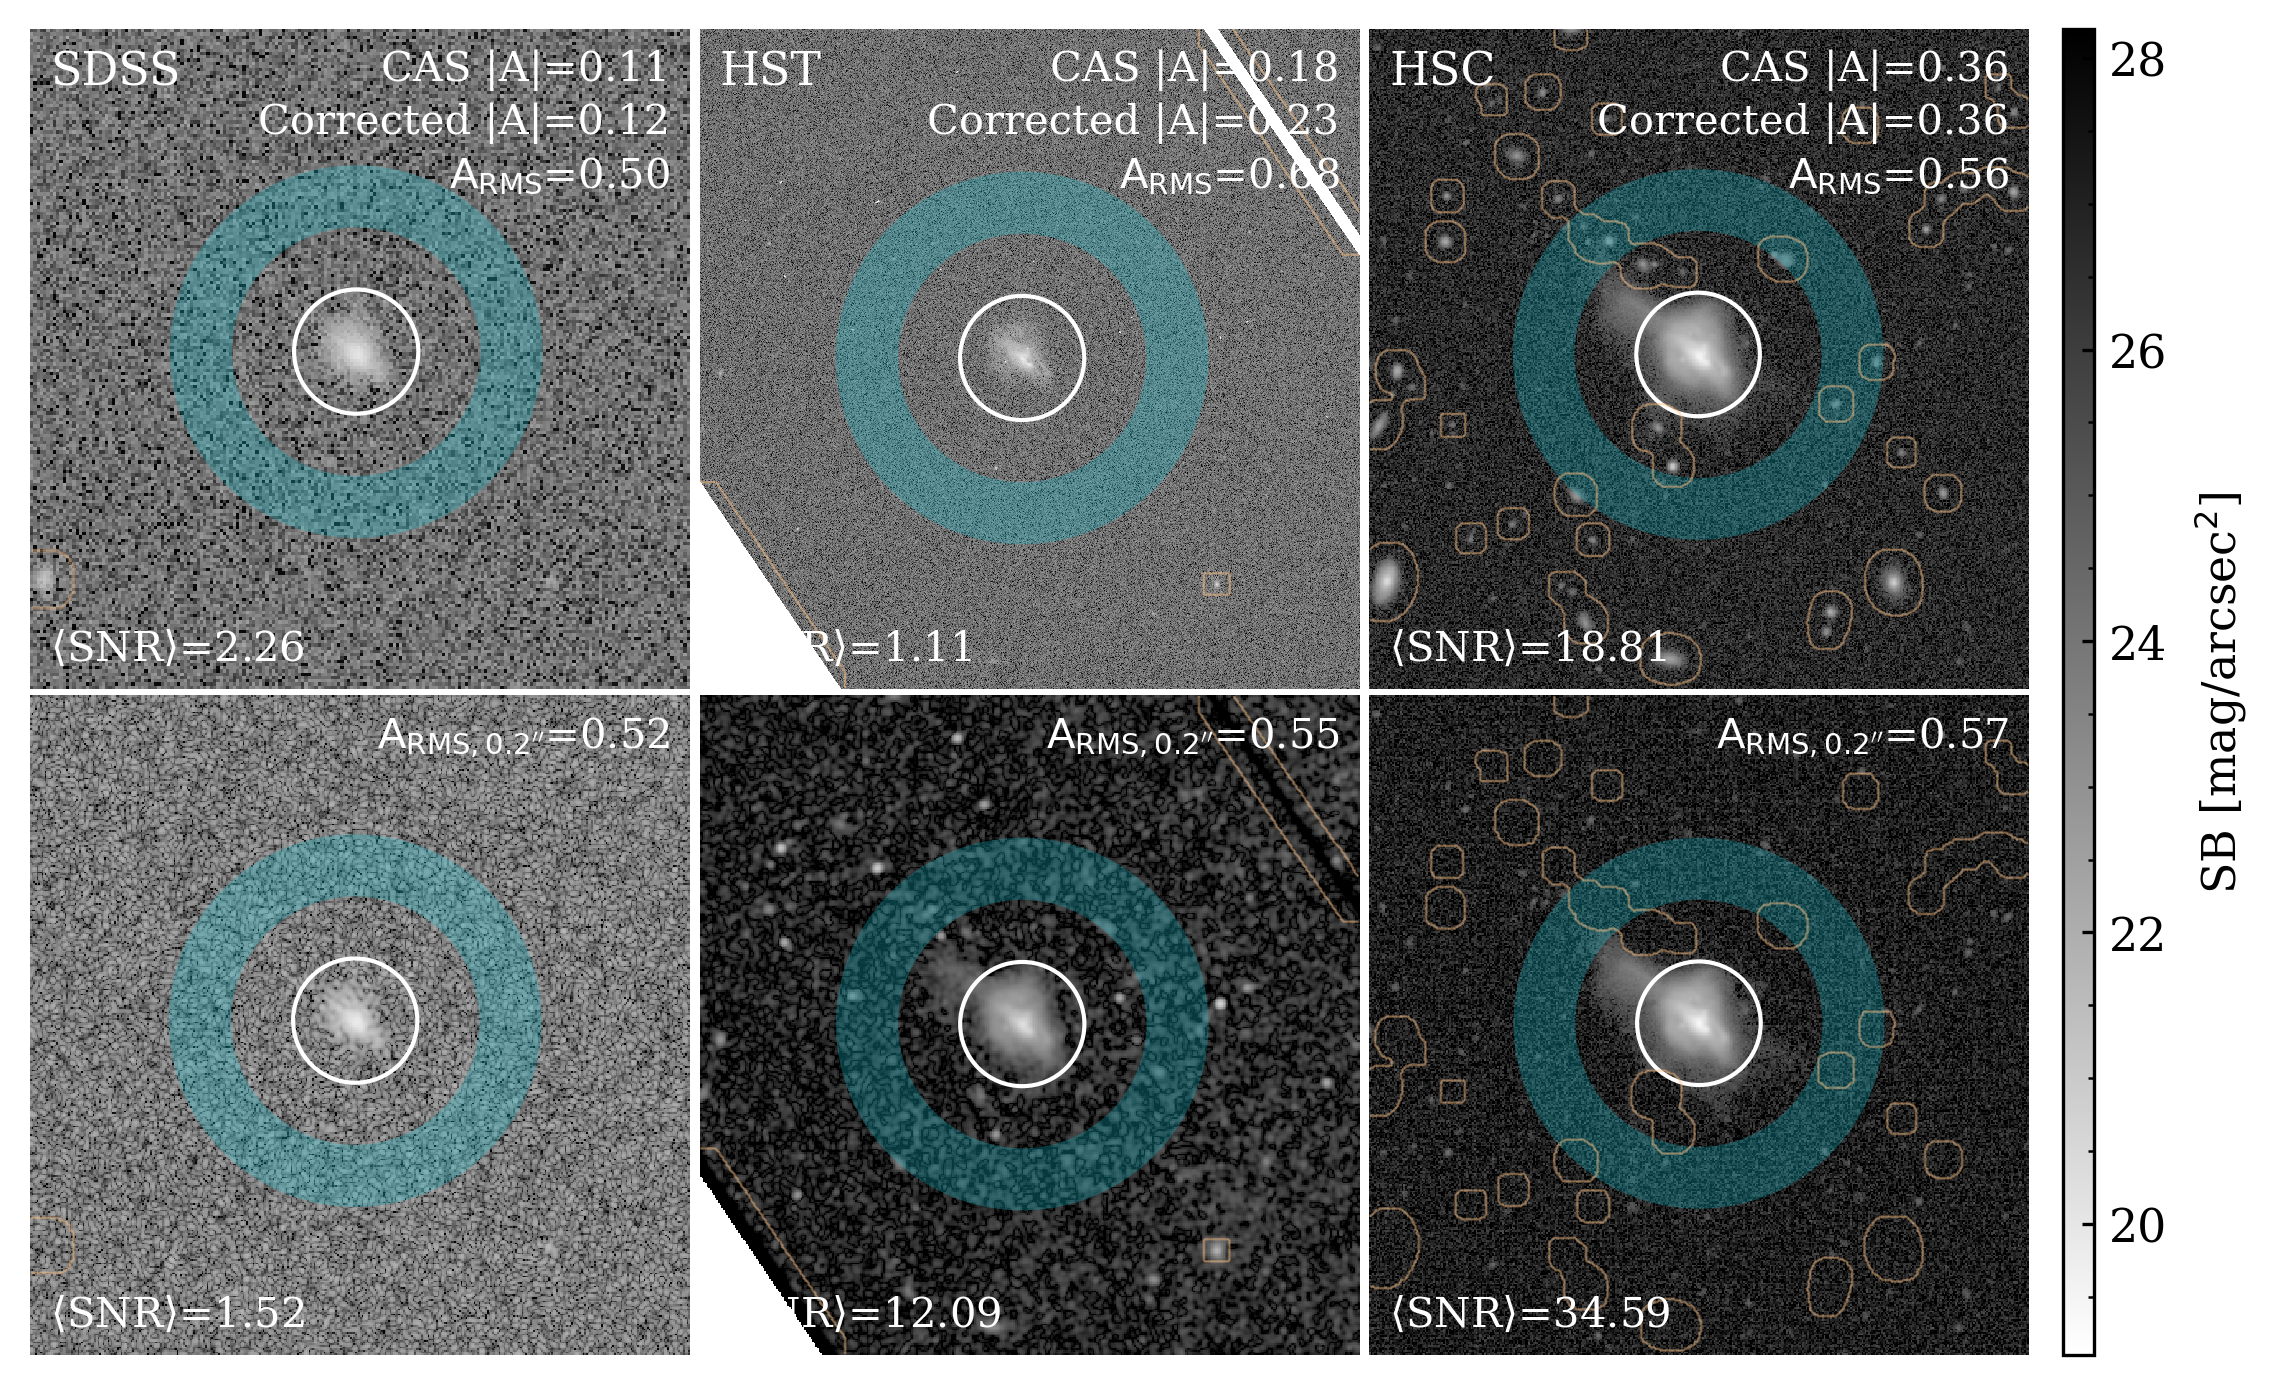

In [251]:
row = df[df['name'] == exname].iloc[0]
res_rows = res_df[res_df['name'] == exname]

# Open files
sdss_f = fits.open(f'data/sdss/i/{row["name"]}.fits')
hst_f = fits.open(f'data/hst/F814W/{row["name"]}.fits')
hsc_f = fits.open(f'data/hsc/{row["name"]}.fits')
files = [sdss_f, hst_f, hsc_f]
    
# For SDSS and HSC, populate pxscale and zp values
sdss_f[0].header['zp'] = 22.5
sdss_f[0].header['pxscale'] = 0.396
hsc_f[0].header['pxscale'] = 0.169
hsc_f[0].header['zp'] = 2.5*np.log10(hsc_f[0].header['FLUXMAG0'])

# Flip the SDSS image
extnames = ['IMAGE','PSF','ERR']
for ext in extnames:
    sdss_f[ext].data = sdss_f[ext].data[::-1].T
    
# # Create segmaps and calculate rpet
# masks, segmaps, rpets = [], [], []
# for f in files:
#     mask, segmap = make_segmap(f)
#     rpet = get_petrosian(f, segmap, mask)[0]
#     masks.append(mask)
#     segmaps.append(segmap)
#     rpets.append(rpet)

# # Deconvolved imagegs
imgs_deconv = fourier_images[0]


# Make axes
fig = plt.figure(figsize=(7.1,4.42))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

labels = ['SDSS', 'HST', 'HSC']
axs = []

mask_cmap = plt.get_cmap('magma')
mask_cmap = colors.LinearSegmentedColormap.from_list('mask_cmap', mask_cmap(np.linspace(0.85, 0.95, 10)))

for i, (f, mask, label, img_deconv) in enumerate(zip(files, masks, labels, imgs_deconv)):
    
    resrow = res_rows.iloc[i]

    # Convert to SB units
    img = -2.5*np.log10(np.abs(f['IMAGE'].data) / f[0].header['pxscale']**2) + f[0].header['zp']
    im_deconv = -2.5*np.log10(np.abs(img_deconv) / desired_pxscale**2) + f[0].header['zp']

    # Make axes
    ax = fig.add_subplot(2,3,(i+1))
    ax_deconv = fig.add_subplot(2,3,(i+4))

    # Plot the images
    im = ax.imshow(img, cmap='gray_r', vmin=19.1, vmax=28.2)
    ax_deconv.imshow(im_deconv, cmap='gray_r', vmin=19.1, vmax=28.2)

    # Overplot the masks
    mask_rescaled = T.rescale(mask, f[0].header['pxscale']/desired_pxscale, order=0)
    ax.contour(mask, cmap=mask_cmap, linewidths=0.5, levels=1, alpha=0.3)
    ax_deconv.contour(mask_rescaled, cmap=mask_cmap, linewidths=0.5, levels=1, alpha=0.3)

    # Overplot 1.5xRpet
    ap_rpet = phot.aperture.CircularAperture(resrow['cent_cas'], 1.5*rpet/f[0].header['pxscale'])
    ap_rpet.plot(ax=ax, color='w', lw=1)
    ap_rpet_deconv = phot.aperture.CircularAperture(resrow['cent_fourier'], 1.5*rpet/desired_pxscale)
    ap_rpet_deconv.plot(ax=ax_deconv, color='w', lw=1)

    # Overplot the sky annulus
    skyap_rpet = phot.aperture.CircularAnnulus(resrow['cent_cas'], 2*1.5*rpet/f[0].header['pxscale'], 3.0*1.5*rpet/f[0].header['pxscale'], )
    skyap_rpet.plot(ax=ax, fc='C9', alpha=0.3, fill=True)
    skyap_rpet_deconv = phot.aperture.CircularAnnulus(resrow['cent_fourier'], 2*1.5*rpet/desired_pxscale, 3.0*1.5*rpet/desired_pxscale)
    skyap_rpet_deconv.plot(ax=ax_deconv, fc='C9', alpha=0.3, fill=True)
    
    # Calculate SNR
    sigma = phot.aperture.ApertureStats(f['IMAGE'].data, skyap_rpet).std
    flux = ap_rpet.do_photometry(f['IMAGE'].data, mask=mask)[0][0]
    area = ap_rpet.do_photometry(~mask)[0][0]
    snr_px = flux / sigma / area
    ax.annotate(fr'$\langle$SNR$\rangle$={snr_px:0.2f}', xy=(0.97, 0.03), xycoords='axes fraction', color='w', size=10, weight=w, va='bottom', ha='left')
    
    # Deconvolved
    sigma = phot.aperture.ApertureStats(img_deconv, skyap_rpet_deconv).std
    flux = ap_rpet_deconv.do_photometry(img_deconv, mask=mask_rescaled)[0][0]
    area = ap_rpet_deconv.do_photometry(~mask_rescaled)[0][0]
    snr_px = flux / sigma / area
    ax_deconv.annotate(fr'$\langle$SNR$\rangle$={snr_px:0.2f}', xy=(0.97, 0.03), xycoords='axes fraction', color='w', size=10, weight=w, va='bottom', ha='right')
    
    

    # Add a label for the instrument
    # color = 'w' 
    ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=11, va='top')

    # Add labels for asymmetry measurements
    w=400
    ax.annotate(f'CAS |A|={resrow["a_cas"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', size=10, weight=w, va='top', ha='right')
    ax.annotate(fr'Corrected |A|={resrow["a_cas_corr"]:0.2f}', xy=(0.97, 0.89), xycoords='axes fraction', color='w', weight=w, size=10, va='top', ha='right')
    ax.annotate(fr'$A_{{RMS}}$={resrow["a_sq"]:0.2f}', xy=(0.97, 0.81), xycoords='axes fraction', color='w', size=10,weight=w,  va='top', ha='right')
    ax_deconv.annotate(fr'$A_{{RMS, 0.2^{{\prime\prime}}}}$={resrow["a_fourier"]:0.2f}', xy=(0.97, 0.97), xycoords='axes fraction', color='w', weight=w, size=10, va='top', ha='right')

    # Change axis limits
    # Define image size
    # size = 30/f[0].header['pxscale']
    # cent = 40/f[0].header['pxscale']
    # ax.set_xlim(cent-size, cent+size)
    # size = 30/desired_pxscale
    # cent = 40/desired_pxscale
    # ax_deconv.set_xlim(cent-size, cent+size)
    
    axs.append([ax, ax_deconv])

# Set axis limits
axs = np.array(axs)
for ax in axs.flatten():
    ax.axis('off')

# Add a colorbar
plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
cax = fig.add_axes([0.955, 0, 0.015, 1])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'SB [mag/arcsec$^2$]', size=11)
    
#     plt.savefig(f'figures/asym_new_0_2/{row["name"]}.pdf', bbox_inches='tight')
#     plt.close(fig)
        
for f in files:
    f.close()

In [231]:
plt.rcParams['xtick.minor.size']=1.5
plt.rcParams['ytick.minor.size']=1.5
plt.rcParams['xtick.major.size']=3
plt.rcParams['ytick.major.size']=3
plt.rcParams['figure.dpi'] = 300

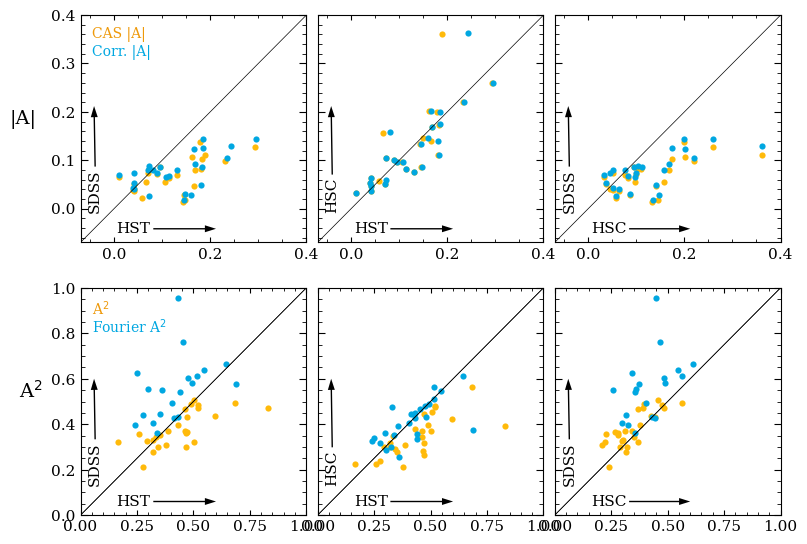

In [23]:
with open('data/res_df_0_1_new.pkl', 'rb') as f:
    res_df2 = pickle.load(f)
    
remove = ['J141910+525151','J095902+021127']
res_df2_good = res_df2[~res_df2.name.isin(remove)]
res_df2_good = res_df2_good.drop_duplicates(subset=['name','instrument'])

sdss = res_df2_good[res_df2_good.instrument == 'SDSS']
hsc =  res_df2_good[res_df2_good.instrument == 'HSC']
hst =  res_df2_good[res_df2_good.instrument == 'HST']

fig, axs = plt.subplots(2,3, figsize=(7,5), sharey='row')

dfs1 = [hst, hst, hsc]
dfs2 = [sdss, hsc, sdss]

s = 80
for i in range(3):
    axs[0,i].scatter(dfs1[i].a_cas, dfs2[i].a_cas, s=s, color='#FFBA0A')
    axs[0,i].scatter(dfs1[i].a_cas_corr, dfs2[i].a_cas_corr, s=s, color='#00A7E1')
    axs[1,i].scatter(dfs1[i].a_sq, dfs2[i].a_sq, s=s, color='#FFBA0A')
    axs[1,i].scatter(dfs1[i].a_fourier, dfs2[i].a_fourier, s=s, color='#00A7E1')
    
for ax in axs.flatten():
    ax.plot([0,1],[0,1], color='k', lw=0.5, transform=ax.transAxes)
    
for ax in axs[0]:
    ax.set_xlim(-0.07, 0.4)
    ax.set_ylim(-0.07, 0.4)
    
for ax in axs[1]:
    ax.plot([0, 5], [0, 5], color='k', lw=0.5)
    ax.set_xlim(0,1.0)
    ax.set_ylim(0,1.0)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    
ylabels = ['SDSS', 'HSC', 'SDSS']
xlabels = ['HST', 'HST', 'HSC']

for i in range(3):
    for ax in axs[:,i]:
        ax.annotate(ylabels[i], xy=(0.06, 0.6), xytext=(0.065, 0.13), xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, ha='center', va='bottom', arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
        ax.annotate(xlabels[i], xy=(0.6, 0.06), xytext=(0.16, 0.06), xycoords='axes fraction', textcoords='axes fraction',
                    ha='left', va='center',  arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
    
axs[0,0].annotate('CAS |A|', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[0,0].annotate('Corr. |A|', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

    
axs[1,0].annotate(r'A$^2$', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[1,0].annotate(r'Fourier A$^2$', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

labels = ['|A|']
axs[0,0].set_ylabel('|A|', rotation=0, labelpad=20, size=14)
axs[1,0].set_ylabel(r'A$^2$', rotation=0, labelpad=15, size=14)
    

plt.subplots_adjust(wspace=0.05)
# plt.savefig('figures/result.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(7,5), sharey='row')

dfs1 = [hst, hst, hsc]
dfs2 = [sdss, hsc, sdss]

s = 80
for i in range(3):
    axs[0,i].scatter(dfs1[i].a_cas, dfs2[i].a_cas, s=s, color='#FFBA0A')
    axs[0,i].scatter(dfs1[i].a_cas_corr, dfs2[i].a_cas_corr, s=s, color='#00A7E1')
    axs[1,i].scatter(dfs1[i].a_sq, dfs2[i].a_sq, s=s, color='#FFBA0A')
    axs[1,i].scatter(dfs1[i].a_fourier, dfs2[i].a_fourier, s=s, color='#00A7E1')
    
for ax in axs.flatten():
    ax.plot([0,1],[0,1], color='k', lw=0.5, transform=ax.transAxes)
    
for ax in axs[0]:
    ax.set_xlim(-0.07, 0.4)
    ax.set_ylim(-0.07, 0.4)
    
for ax in axs[1]:
    ax.plot([0, 5], [0, 5], color='k', lw=0.5)
    ax.set_xlim(0.005, 5)
    ax.set_ylim(0.005, 5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ylabels = ['SDSS', 'HSC', 'SDSS']
xlabels = ['HST', 'HST', 'HSC']

for i in range(3):
    for ax in axs[:,i]:
        ax.annotate(ylabels[i], xy=(0.06, 0.6), xytext=(0.065, 0.13), xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, ha='center', va='bottom', arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
        ax.annotate(xlabels[i], xy=(0.6, 0.06), xytext=(0.16, 0.06), xycoords='axes fraction', textcoords='axes fraction',
                    ha='left', va='center',  arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=8))
    
axs[0,0].annotate('CAS |A|', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[0,0].annotate('Corr. |A|', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

    
axs[1,0].annotate(r'A$^2$', color='#EE990A', xy=(0.05, 0.95), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)
axs[1,0].annotate(r'Fourier A$^2$', color='#00A7E1', xy=(0.05, 0.87), xycoords='axes fraction', va='top', ha='left', size=10, weight=500)

labels = ['|A|']
axs[0,0].set_ylabel('|A|', rotation=0, labelpad=20, size=14)
axs[1,0].set_ylabel(r'A$^2$', rotation=0, labelpad=15, size=14)
    

plt.subplots_adjust(wspace=0.05)
# plt.savefig('figures/result.png', bbox_inches='tight')

In [3]:
from scipy.integrate import quad

In [31]:
def normal(x, A, mu, std):
    return A * np.exp(-(x-mu)**2 / (2*std**2)) / (np.sqrt(2*np.pi)*std)

def fun(x):
    
    y1 = normal(x, 1, -3, 0.6)
    y2 = normal(x, 0.7, 1, 0.5)
    y3 = normal(x, 0.1, 0, 0.1)
    y4 = normal(x, 0.5, -2, 1)
    
    # y = np.sin(x)
    return y1+y2#+y3+y4

xs = np.linspace(-10, 10, 500)
ys = fun(xs)

# plt.plot(xs, ys, color='k', label='I(x)')
# plt.xlabel('x')

x0s = np.linspace(-3, 3, 150)
asyms = []
for x0 in x0s:
    
    asym = quad(lambda x: np.abs(fun(x) - fun(2*x0-x)), -np.inf, np.inf)
    asyms.append(asym[0])
    
    # ys_rot = fun(2*x0 - xs)

# x0s = [-1]#, 1]
# colors = ['C1', 'C1']
# for x0, color in zip(x0s, colors):
#     ys_rot = fun(2*x0 - xs)
#     yplot = np.abs(ys-ys_rot)
#     plt.plot(xs, yplot, color=color, lw=1, ls='--', label='|Difference|')
#     plt.plot(xs, ys_rot, color=color, lw=1, label=f'Reflect about {x0}')
#     plt.legend(frameon=False)

/tmp/ipykernel_957/227597449.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  asym = quad(lambda x: np.abs(fun(x) - fun(2*x0-x)), -np.inf, np.inf)


In [32]:
# ys = ex_hst_f[0].data
# ys = T.rescale(ys, 0.1)
# ys = ys[101]
# psf = Gaussian1DKernel(30, x_size=len(ys))
# psf_fft = (fft(psf))

# # # [1010]
# xs = np.arange(len(ys))

Text(1.4, 3, 'Best x0')

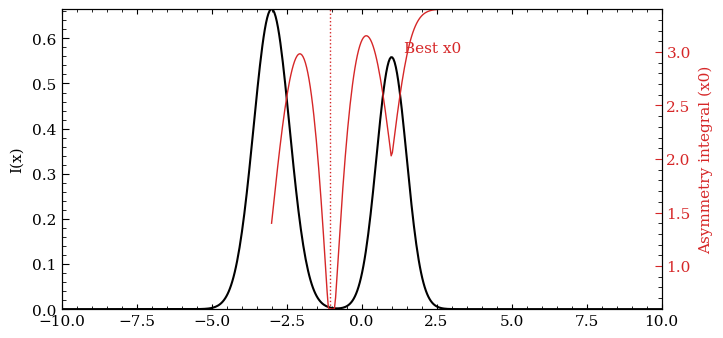

In [33]:
# plt.plot(xs, ys, color='k', label='I(x)')
# plt.xlabel('x')

fig = plt.figure(figsize=(6,3))
ax = plt.axes()
ax.plot(xs, ys, color='k')
ax.set_ylabel('I(x)')
ax2 = ax.twinx()
ax2.plot(x0s, asyms, color='C3', lw=1)
ax2.tick_params(color='C3', labelcolor='C3')
ax2.set_ylabel('Asymmetry integral (x0)', color='C3')


ax2.axvline(x0s[np.argmin(asyms)], color='C3', lw=1, ls=':')
ax2.annotate('Best x0', xy=(1.4, 3), xycoords='data', color='C3')

In [34]:
from scipy.fftpack import fft, rfft, fftfreq, ifft, fftshift
from scipy.optimize import minimize_scalar
from astropy.convolution import Gaussian1DKernel

(-1e-08, 1e-08)

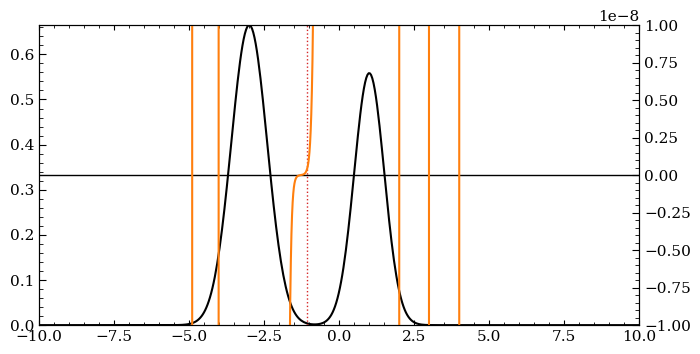

In [36]:
fig = plt.figure(figsize=(6,3))
yfft = fft(ys)
dx = np.diff(xs)[0]
freq = np.fft.fftfreq(len(ys), d=dx)
deriv = yfft*yfft * freq * 1j * 2*np.pi

res = ifft(deriv) 

ax = plt.axes()
plt.plot(xs, ys, color='k')
plt.axvline(x0s[np.argmin(asyms)], color='C3', lw=1, ls=':')

ax2 = plt.twinx()
ax2.axhline(0, color='k', lw=1)
ax2.plot(xs/2, res, color='C1')
ax2.set_ylim(-0.00000001, 0.00000001)
# ax2.set_yscale('log')

# plt.yscale('log')